# Demo - Amazon Rekognition

Vamos utilizar algumas das APIs do Rekognition

In [164]:
import boto3 # aws python sdk
import time
import json
import numpy as np
import pandas as pd
from zipfile import ZipFile
from datetime import datetime
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import IPython.display as disp
from IPython.display import Markdown
from IPython.display import JSON

In [4]:
image_dir = 'sample-data/'

## Funções auxiliares

In [5]:
def load_image(filename):
    with open(filename, "rb") as imageFile:
      f = imageFile.read()
      return bytearray(f)

In [6]:
def convert_to_dataframe(labels):
    data = {'Label':[], 'Confidence':[]}
    for label in labels:
        data['Label'].append(label['Name'])
        data['Confidence'].append(label['Confidence'])
    return pd.DataFrame(data)[['Label', 'Confidence']]

In [7]:
def create_bounding_box(bbox, size):
    if len(bbox) != 4:
        return None
    return [ 
        bbox['Left']*size[0], bbox['Top']*size[1],
        (bbox['Left']*size[0])+bbox['Width']*size[0], 
        (bbox['Top']*size[1])+bbox['Height']*size[1]
    ]

In [8]:
def draw_bounding_box(filename, bbox, color, size):
    img = Image.open(filename)
    draw = ImageDraw.Draw(img)
    draw.line([(bbox[0], bbox[1]), (bbox[2], bbox[1])], fill=color, width=4)
    draw.line([(bbox[2], bbox[1]), (bbox[2], bbox[3])], fill=color, width=4)
    draw.line([(bbox[2], bbox[3]), (bbox[0], bbox[3])], fill=color, width=4)
    draw.line([(bbox[0], bbox[1]), (bbox[0], bbox[3])], fill=color, width=4)
    del draw
    plt.figure(figsize = (20,size))
    plt.imshow(img)

In [9]:
def print_lines_confidence(lines, lenght):
    try:
        for l in range(1, lenght):
            print(lines[l]['Text'] + '({})'.format(lines[l]['Confidence']))
    except Exception as e:
        print("Too long")

In [10]:
def delete_collection(name):
    try:
        response = rekognition.delete_collection(
            CollectionId=name
        )
    except Exception as e:
        print("Collection not found")

## Amazon Rekognition

O Amazon Rekognition facilita a adição de análises de imagens e vídeos aos seus aplicativos. Basta fornecer uma imagem ou um vídeo à API do Amazon Rekognition, e o serviço poderá identificar objetos, pessoas, texto, cenas e atividades. 

Documentação: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/rekognition.html

In [158]:
# api client
rekognition = boto3.client('rekognition')

### Detecção de texto

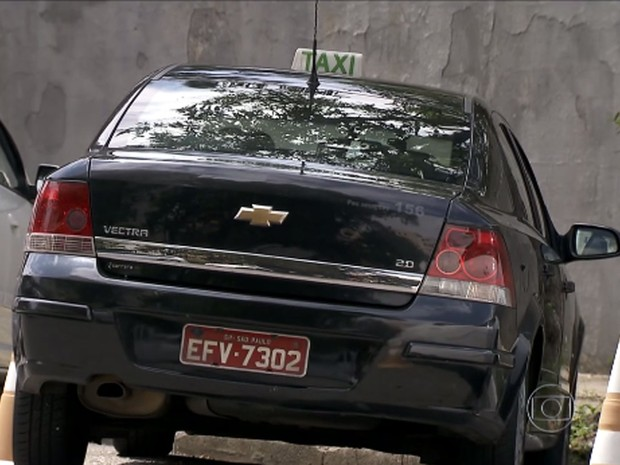

In [19]:
disp.Image(image_dir + 'carro.jpg', width=400)

In [20]:
response = rekognition.detect_text(
    Image={'Bytes': load_image(image_dir + 'carro.jpg')}
)

for i in response['TextDetections']:
    if i['Type']=='WORD' and i['Confidence'] >= 95:
        print( '%s - Confidence[%f]' % (i['DetectedText'], i['Confidence']) )

TAXI - Confidence[97.102127]
156 - Confidence[95.075706]
VECTRA - Confidence[97.814827]
2D - Confidence[95.179008]
EFV-7302 - Confidence[99.036530]


### Detecção de objetos

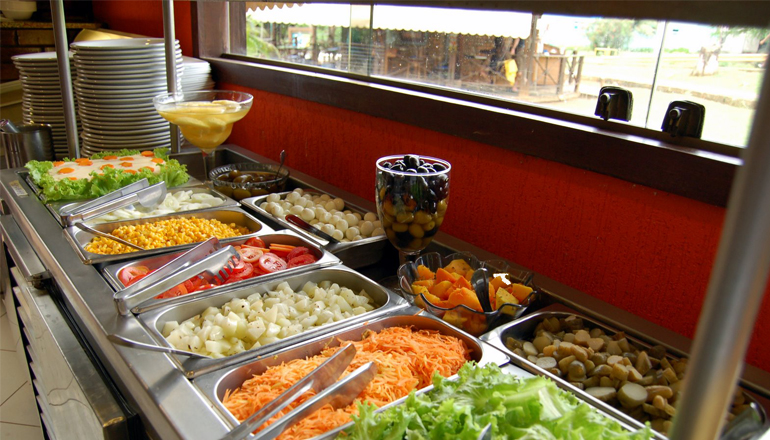

In [21]:
disp.Image(image_dir + 'comida1.jpg', width=400)

In [24]:
response = rekognition.detect_labels(
    Image={'Bytes': load_image(image_dir + 'comida1.jpg')},
    MaxLabels=5,
    MinConfidence=70
)

convert_to_dataframe(response['Labels'])

Label  Confidence
0        Food   99.977837
1        Meal   99.977837
2   Cafeteria   99.876633
3  Restaurant   99.876633
4       Salad   90.751343

### Reconhecimento de pessoas públicas

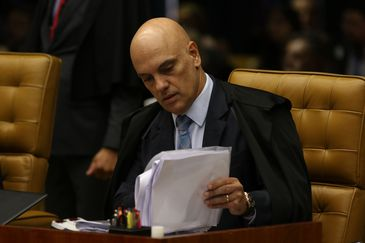

In [25]:
disp.Image(image_dir + 'agenciabrasil-2.jpg', width=300)

Alexandre de Moraes 99.99866485595703


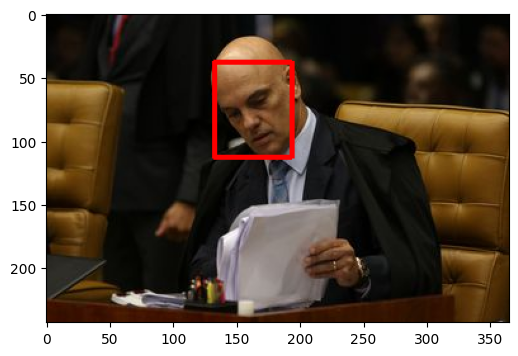

In [26]:
response = rekognition.recognize_celebrities(
    Image={'Bytes': load_image(image_dir + 'agenciabrasil-2.jpg')}
)

img = Image.open(image_dir + 'agenciabrasil-2.jpg')
bbox = create_bounding_box(response['CelebrityFaces'][0]['Face']['BoundingBox'], img.size )
confidence = response['CelebrityFaces'][0]['Face']['Confidence']
name = response['CelebrityFaces'][0]['Name']

print(name, confidence)
draw_bounding_box(image_dir + 'agenciabrasil-2.jpg', bbox, 'red', 4)

### Análise facial

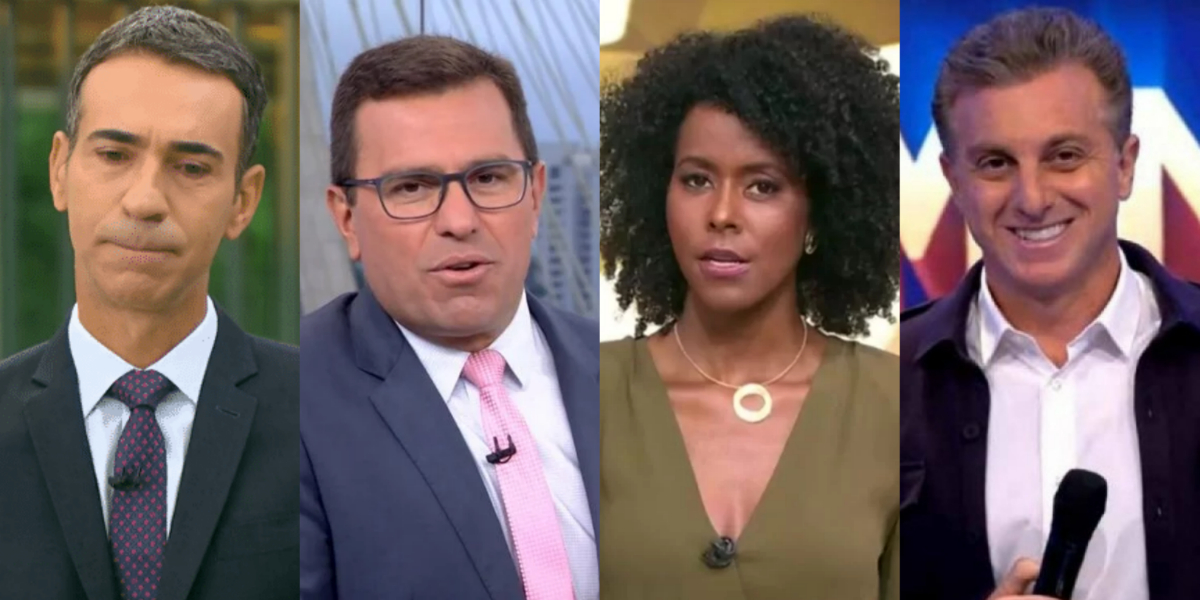

In [29]:
disp.Image(image_dir + 'pessoas1.jpg', width=400)

48 Male
47 Male
51 Male
36 Female


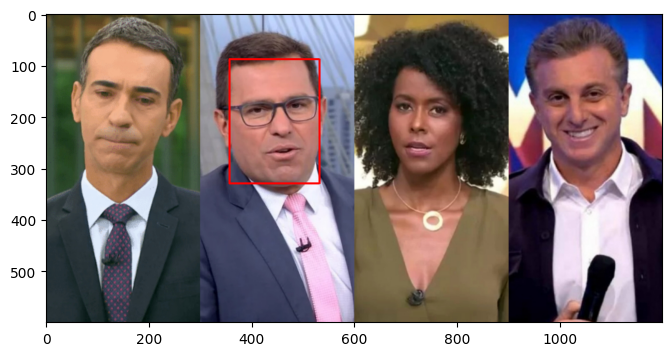

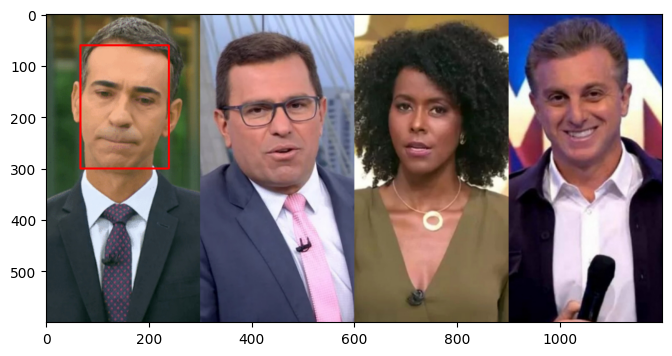

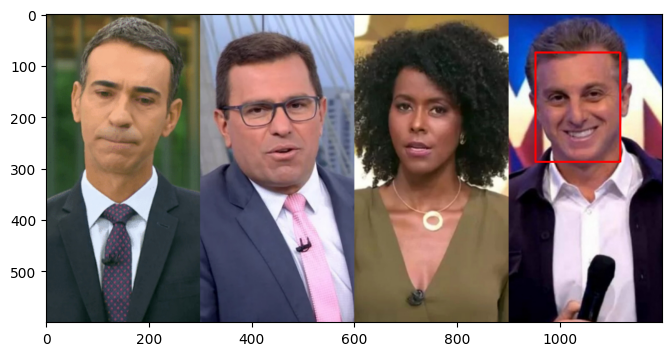

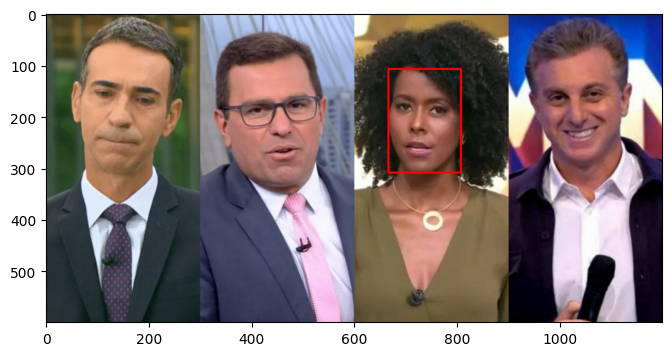

In [33]:
response = rekognition.detect_faces(
    Image={'Bytes': load_image(image_dir + 'pessoas1.jpg')},
    Attributes=['ALL']
)

img = Image.open(image_dir + 'pessoas1.jpg')

for face in response['FaceDetails']:
    age = face['AgeRange']['High']
    gender = face['Gender']['Value']
    print(age, gender)

    bbox = create_bounding_box(face['BoundingBox'], img.size )
    draw_bounding_box(image_dir + 'pessoas1.jpg', bbox, 'red', 4)

### Comparação facial

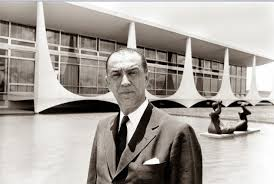

In [34]:
disp.Image(image_dir + 'jk-1.jpg', width=300)

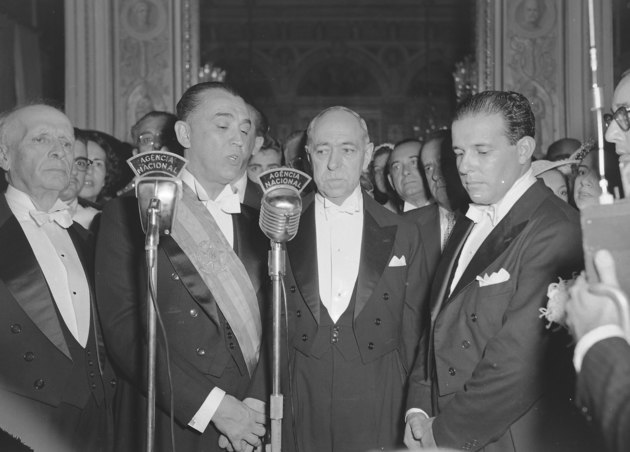

In [35]:
disp.Image(image_dir + 'jk-2.jpg', width=300)

In [36]:
response = rekognition.compare_faces(
    SourceImage={'Bytes': load_image(image_dir + 'jk-1.jpg')},
    TargetImage={'Bytes': load_image(image_dir + 'jk-2.jpg')}
)

imgA = Image.open(image_dir + 'jk-1.jpg')
imgB = Image.open(image_dir + 'jk-2.jpg')

similarity = response['FaceMatches'][0]['Similarity']
bboxA = create_bounding_box( response['SourceImageFace']['BoundingBox'], imgA.size )
bboxB = create_bounding_box( response['FaceMatches'][0]['Face']['BoundingBox'], imgB.size )

Similarity: 99.68911743164062


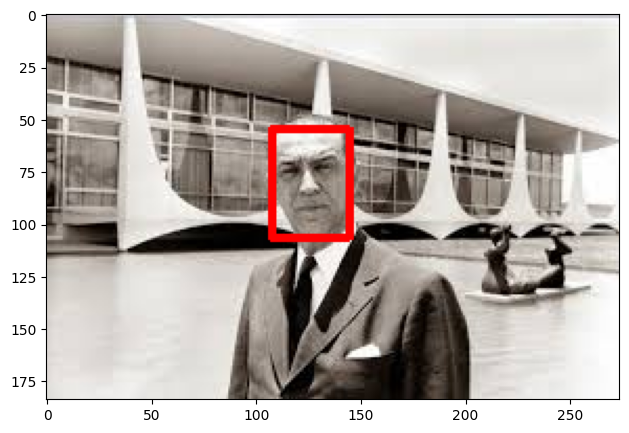

In [37]:
print( 'Similarity: {}'.format( similarity ) )
if bboxA: draw_bounding_box(image_dir + 'jk-1.jpg', bboxA, 'red', 5)

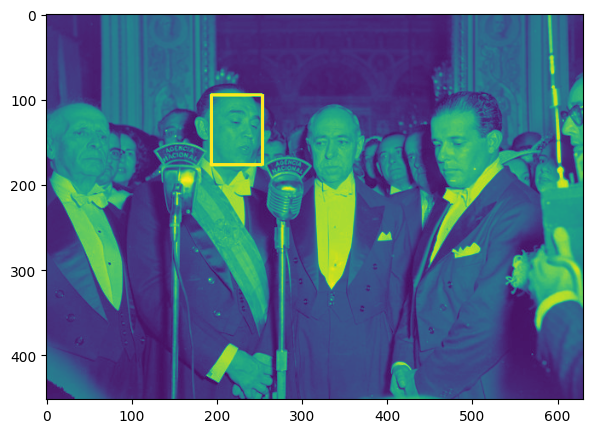

In [40]:
if bboxB: draw_bounding_box(image_dir + 'jk-2.jpg', bboxB, 'white', 5)

### Busca por faces

O Rekognition possui uma feature para que possamos criar coleções de faces, efetuando uma busca otimizada ao receber uma nova face

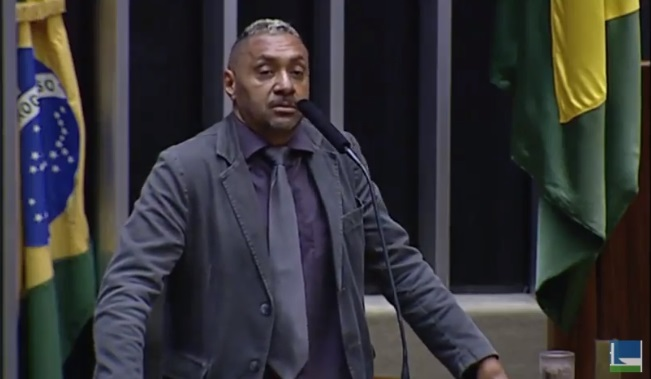

In [41]:
disp.Image(image_dir + 'tiririca-1.jpg', width='400')

In [42]:
try:
    delete_collection("Deputados")
    response = rekognition.create_collection(
        CollectionId='Deputados'
    )
    faces = {
        'Tiririca': image_dir + 'tiririca-1.jpg'
    }
    for ext_id, image_name in faces.items():
        response = rekognition.index_faces(
            CollectionId='Deputados',
            Image={'Bytes': load_image(image_name)},
            ExternalImageId=ext_id,
        )
        if len(response['FaceRecords']) > 0:
            for i in response['FaceRecords']:
                print( ext_id, i['Face']['FaceId'])
except Exception as e:
    print(e)

Tiririca 72ad6a8b-d010-4d40-b9d5-146d15d83e18


Agora iremos enviar uma imagem diferente da utilizada na coleção e buscar por faces conhecidas pela coleção

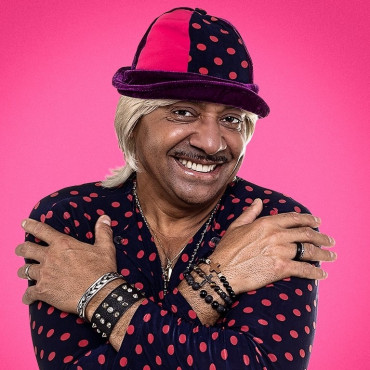

In [43]:
disp.Image(image_dir + 'tiririca-2.jpg', width='400')

In [44]:
faces = rekognition.search_faces_by_image(
    CollectionId='Deputados',
    Image={ 'Bytes': load_image( image_dir + 'tiririca-2.jpg') },
    MaxFaces=10
)['FaceMatches']

print('# Mached faces in the collection: {}'.format( len(faces)))
print('FaceId: {} - Similarity: {}'.format(faces[0]['Face']['ExternalImageId'], faces[0]['Similarity']))

# Mached faces in the collection: 1
FaceId: Tiririca - Similarity: 99.55577850341797


### Detecção de EPI

In [63]:
disp.Image(image_dir + 'cozinha.jpg', width='400')

In [84]:
cozinha = rekognition.detect_protective_equipment(
    Image={ 'Bytes': load_image( image_dir + 'cozinha.jpg') },
    SummarizationAttributes={
        'MinConfidence': 60,
        'RequiredEquipmentTypes': [
            'FACE_COVER',
        ]
    }
)

JSON(cozinha['Summary'])

<IPython.core.display.JSON object>

In [71]:
disp.Image(image_dir + 'cozinha2.jpeg', width='400')

In [85]:
cozinha = rekognition.detect_protective_equipment(
    Image={ 'Bytes': load_image( image_dir + 'cozinha2.jpeg') },
    SummarizationAttributes={
        'MinConfidence': 60,
        'RequiredEquipmentTypes': [
            'FACE_COVER',
        ]
    }
)

JSON(cozinha['Summary'])

<IPython.core.display.JSON object>

## Criando modelos customizados

In [73]:
rekognition_custom_bucket = 'custom-labels-console-us-east-1-f0c7253102'

### Download do dataset

- https://github.com/a1302z/OktoberfestFoodDataset

In [76]:
oktoberfest_food_train = "'https://dataserv.ub.tum.de/s/m1487154/download?path=%2Fdataset&files=train.zip&downloadStartSecret=ziok01cyhea'"
oktoberfest_food_test = "'https://dataserv.ub.tum.de/s/m1487154/download?path=%2Fdataset&files=test.zip&downloadStartSecret=gznk7wq0la'"

!mkdir -p ./oktoberfest_food_train/zip
!mkdir -p ./oktoberfest_food_train/images
!mkdir -p ./oktoberfest_food_train/annotations
!mkdir -p ./oktoberfest_food_test/zip
!mkdir -p ./oktoberfest_food_test/images
!mkdir -p ./oktoberfest_food_test/annotations

!curl $oktoberfest_food_train --output ./oktoberfest_food_train/zip/train.zip
!curl $oktoberfest_food_test --output ./oktoberfest_food_test/zip/test.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  652M  100  652M    0     0  1512k      0  0:07:21  0:07:21 --:--:-- 2633k34k      0  0:10:45  0:00:15  0:10:30 1638k   0  1157k      0  0:09:36  0:00:18  0:09:18 1752k     0  0:07:25  0:00:37  0:06:48 1404k0     0  1616k      0  0:06:53  0:00:49  0:06:04 1940k  0  0:05:49  0:01:28  0:04:21 1847k 0  1896k      0  0:05:52  0:01:43  0:04:09 2269k 0:02:41 2076k  0  1896k      0  0:05:52  0:03:39  0:02:13 1453k0     0  1873k      0  0:05:56  0:04:09  0:01:47 1739k   0     0  1879k      0  0:05:55  0:04:20  0:01:35 1331k 0  1712k      0  0:06:30  0:05:03  0:01:27  190kk      0  0:06:59  0:05:28  0:01:31  205k    0     0  1542k      0  0:07:12  0:05:57  0:01:15  272k   0     0  1532k      0  0:07:15  0:06:00  0:01:15  274k0     0  1525k      0  0:07:17  0:06:02  0:01:15  275k 0  0:07:27  0:06:50  0:00:37 2266k  610M    0     0  1499

In [82]:
with ZipFile("./oktoberfest_food_train/zip/train.zip", 'r') as zObject:
    for file_info in zObject.infolist():
        if file_info.filename.endswith(".jpg"):
            zObject.extract(file_info, path="./oktoberfest_food_train/images")
        elif file_info.filename.endswith(".txt"):
            zObject.extract(file_info, path="./oktoberfest_food_train/annotations")
zObject.close()

with ZipFile("./oktoberfest_food_test/zip/test.zip", 'r') as zObject:
    for file_info in zObject.infolist():
        if file_info.filename.endswith(".jpg"):
            zObject.extract(file_info, path="./oktoberfest_food_test/images")
        elif file_info.filename.endswith(".txt"):
            zObject.extract(file_info, path="./oktoberfest_food_test/annotations")
zObject.close()

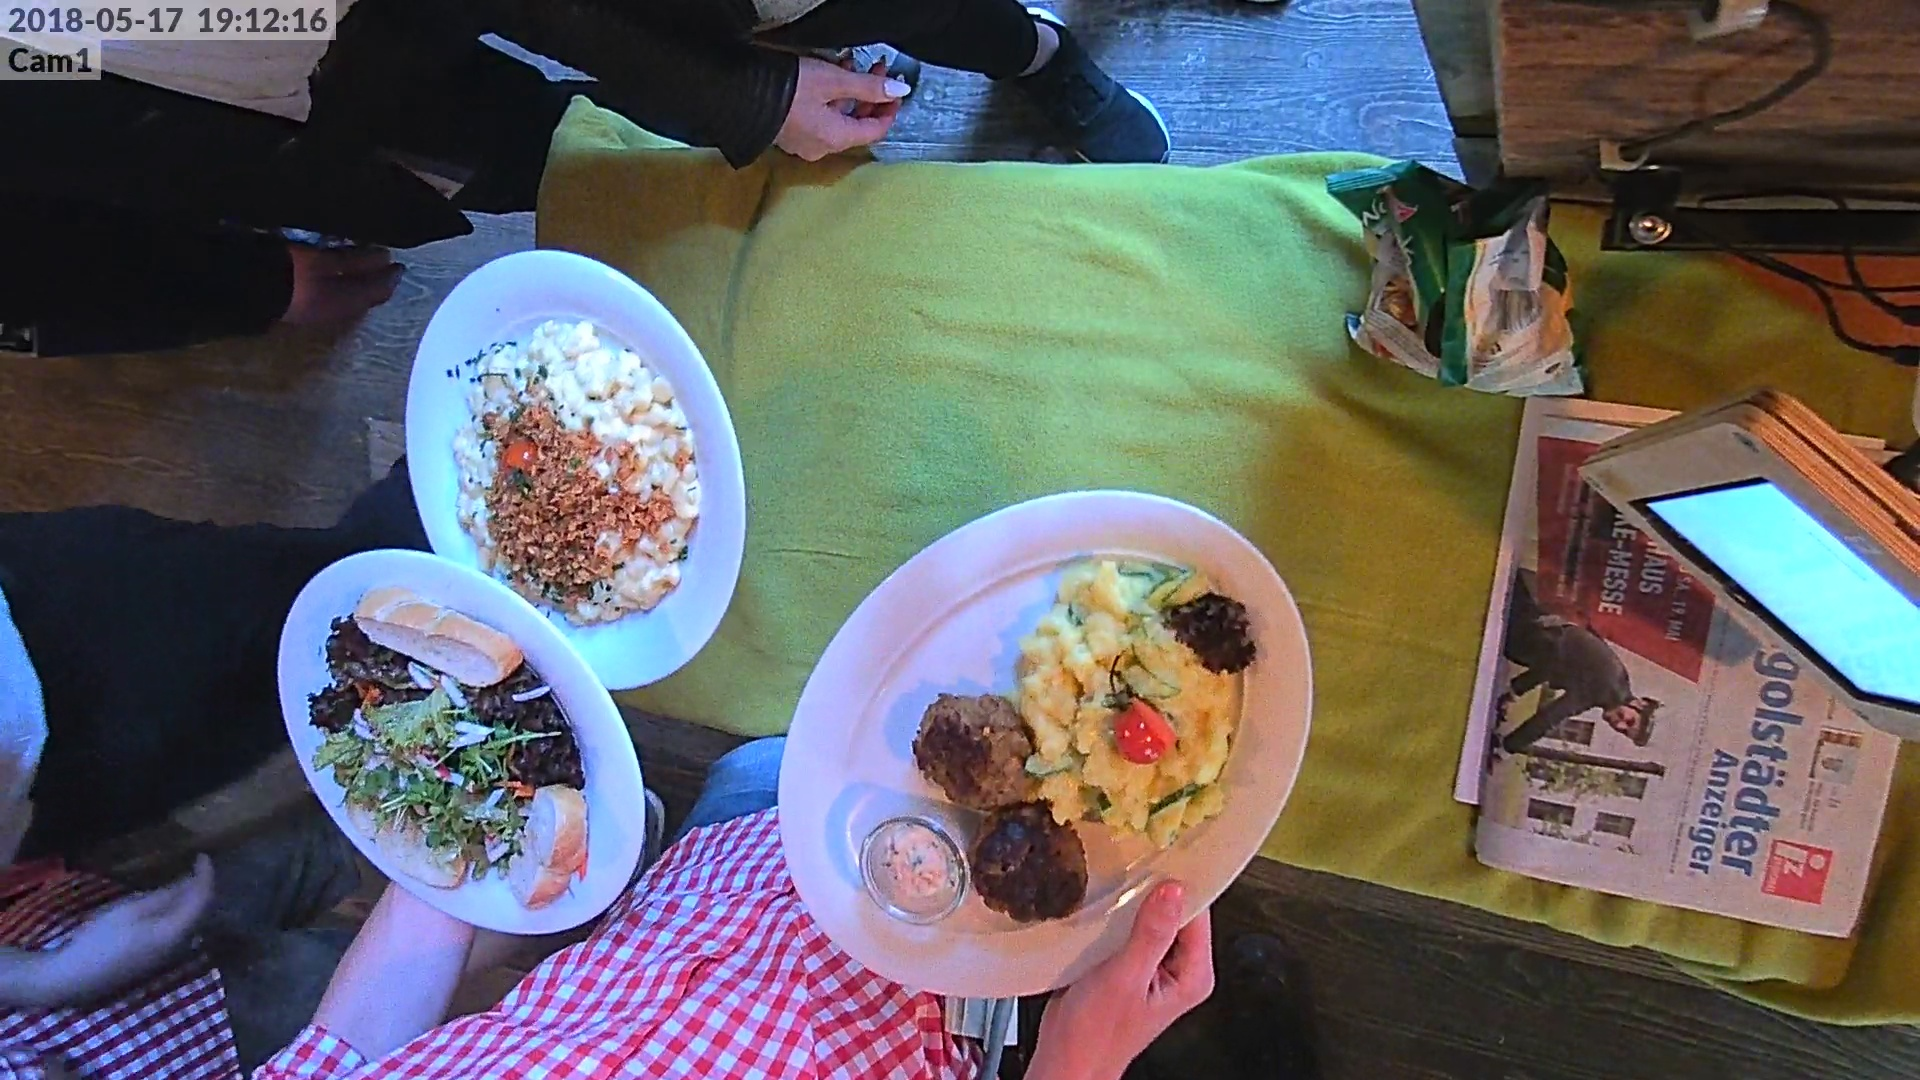

In [87]:
disp.Image("./oktoberfest_food_train/images/train/1526577135142_20.jpg", width='400')

In [139]:
category_names = [
    "Cerveja",
    "Caneca de cerveja",
    "Cerveja de trigo",
    "Refrigerante de cola",
    "Água",
    "Salsicha com molho de curry",
    "Vinho branco",
    "Bebida mista de suco de maçã",
    "Licor de ervas",
    "Batatas fritas",
    "Hambúrguer",
    "Pera Williams",
    "Pretzel dos Alpes",
    "Cesta de lanches",
    "Massa com queijo"
]

In [140]:
# <filename> <number of objects> <classid1> <x1> <y1> <w1> <h1> <classid2> <x2> <y2> <w2> <h2> ...
with open("./oktoberfest_food_train/annotations/train/files.txt") as f:
    annotations = f.readlines()

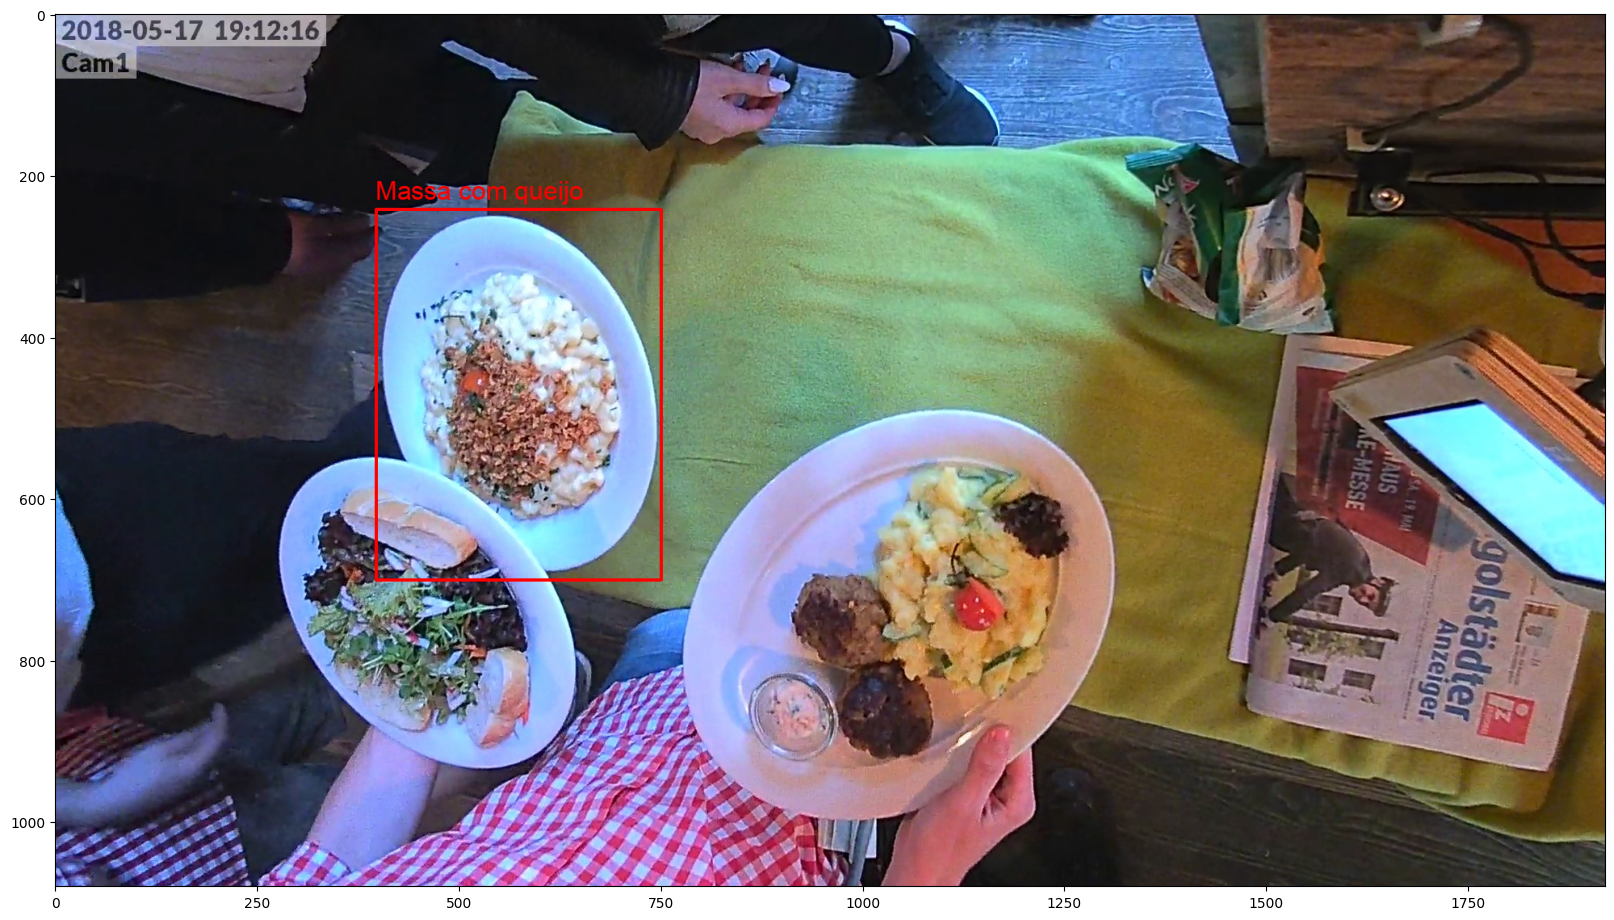

In [147]:
for annotation in annotations:
    columns = annotation.split(' ')
    if columns[0] == "1526577135142_20.jpg":
        img = Image.open(f"./oktoberfest_food_train/images/train/{columns[0]}")
        draw = ImageDraw.Draw(img)
        for object in range(int(columns[1])):
            c, x, y, w, h = [int(x) for x in columns[2+5*object:7+5*object]]
            bbox = [x, y, x+w, y+h]
            draw.text((x, y-40), category_names[c], font=ImageFont.truetype("Pillow/Tests/fonts/Arial.ttf", 32), fill="red")
            draw.line([(bbox[0], bbox[1]), (bbox[2], bbox[1])], fill="red", width=4)
            draw.line([(bbox[2], bbox[1]), (bbox[2], bbox[3])], fill="red", width=4)
            draw.line([(bbox[2], bbox[3]), (bbox[0], bbox[3])], fill="red", width=4)
            draw.line([(bbox[0], bbox[1]), (bbox[0], bbox[3])], fill="red", width=4)
            del draw
            plt.figure(figsize = (20,400))
            plt.imshow(img)

### Criar arquivo de manifesto

In [155]:
def generate_manifest_file(images_mtdata, image_prefix, manifest_file_path):
    images_json = []
    
    for image_mtdata in images_mtdata:
        columns = image_mtdata.split(' ')
        img = Image.open(image_prefix+columns[0])
        img_size = {
            "width": img.width,
            "height": img.height,
            "depth": 3
        }
        confidence = {}
        objects = []
        class_map = {}
        annotations = []
        
        for object in range(int(columns[1])):
            c, x, y, w, h = [int(x) for x in columns[2+5*object:7+5*object]]
            class_map[str(c)] = category_names[c]
            confidence["confidence"] = 1
            objects.append(confidence)
            annotations.append({
                "class_id": c,
                "top": y,
                "left": x,
                "width": w,
                "height": h
            })
            
        bbx = {
            "image_size" : [img_size],
            "annotations" : annotations
        }

        bbx_mtdata = {
            "objects" : objects,
            "class-map" : class_map,
            "type": "groundtruth/object-detection",
            "human-annotated": "yes",
            "creation-date": datetime.today().strftime('%Y-%m-%dT%H:%m:%S'), 
            "job-name": "oktoberfest"
        }
                
        singl_file = {
            "source-ref" : f's3://{rekognition_custom_bucket}/oktoberfest_food/dataset/{columns[0]}',
            "bounding-box" : bbx,
            "bounding-box-metadata" : bbx_mtdata
        }
        
        images_json.append(json.dumps(singl_file) + " \n")
    
    final_file = open(manifest_file_path, "w")
    final_file.writelines(images_json)
    final_file.close()

In [156]:
generate_manifest_file(annotations, './oktoberfest_food_train/images/train/', './oktoberfest_food_train/annotations/train/dataset.manifest')

### Criar projeto e importar dataset

In [ ]:
cl_project = rekognition.create_project(
    ProjectName='oktoberfest_food'
)
JSON(cl_project)

In [160]:
!aws s3 cp ./oktoberfest_food_train/images/train/ s3://$rekognition_custom_bucket/oktoberfest_food/dataset/ --recursive
!aws s3 cp ./oktoberfest_food_train/annotations/train/dataset.manifest s3://$rekognition_custom_bucket/oktoberfest_food/dataset/dataset.manifest

upload: oktoberfest_food_train/images/train/.ipynb_checkpoints/1526577135142_45-checkpoint.jpg to s3://custom-labels-console-us-east-1-f0c7253102/oktoberfest_food/dataset/.ipynb_checkpoints/1526577135142_45-checkpoint.jpg
upload: oktoberfest_food_train/images/train/.ipynb_checkpoints/1526823115771_45-checkpoint.jpg to s3://custom-labels-console-us-east-1-f0c7253102/oktoberfest_food/dataset/.ipynb_checkpoints/1526823115771_45-checkpoint.jpg
upload: oktoberfest_food_train/images/train/.ipynb_checkpoints/1526735321021_70-checkpoint.jpg to s3://custom-labels-console-us-east-1-f0c7253102/oktoberfest_food/dataset/.ipynb_checkpoints/1526735321021_70-checkpoint.jpg
upload: oktoberfest_food_train/images/train/.ipynb_checkpoints/1526764755934_45-checkpoint.jpg to s3://custom-labels-console-us-east-1-f0c7253102/oktoberfest_food/dataset/.ipynb_checkpoints/1526764755934_45-checkpoint.jpg
upload: oktoberfest_food_train/images/train/.ipynb_checkpoints/1526829157546_20-checkpoint.jpg to s3://custom-la

In [162]:
cl_dataset_train = rekognition.create_dataset(
                        DatasetSource={
                            'GroundTruthManifest': {
                                'S3Object': {
                                    'Bucket': rekognition_custom_bucket,
                                    'Name': 'oktoberfest_food/dataset/dataset.manifest'
                                }
                            }
                        },
                        DatasetType='TRAIN',
                        ProjectArn=cl_project['ProjectArn']
                    )
JSON(cl_dataset_train)

<IPython.core.display.JSON object>

In [165]:
chk_status = True
starttime = time.time()
while (chk_status):
    ## wait for 2 minute. To check status every 2 minutes
    time.sleep (120)
    dataset_status = rekognition.describe_dataset(
                            DatasetArn=cl_dataset_train['DatasetArn']
                        )
    if ( (dataset_status['DatasetDescription']['Status'] != 'CREATE_IN_PROGRESS') ):
        chk_status = False
        
JSON(dataset_status)

<IPython.core.display.JSON object>

In [167]:
## Empty test dataset
cl_dataset_test = rekognition.create_dataset(
                DatasetType='TEST',
                ProjectArn=cl_project['ProjectArn']
            )
JSON(cl_dataset_test)

<IPython.core.display.JSON object>

In [168]:
## Split the dataset that was created earlier into Training and Validation dataset
cl_distribute_dataset = rekognition.distribute_dataset_entries(
                            Datasets=[
                                {
                                    'Arn': cl_dataset_train['DatasetArn']
                                },
                                {
                                    'Arn': cl_dataset_test['DatasetArn']
                                }
                            ]
                        )

## Testando o modelo

In [173]:
#Copyright 2020 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#PDX-License-Identifier: MIT-0 (For details, see https://github.com/awsdocs/amazon-rekognition-custom-labels-developer-guide/blob/master/LICENSE-SAMPLECODE.)

import boto3
import io
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont

def display_image(bucket,photo,response):
    # Load image from S3 bucket
    s3_connection = boto3.resource('s3')

    s3_object = s3_connection.Object(bucket,photo)
    s3_response = s3_object.get()

    stream = io.BytesIO(s3_response['Body'].read())
    image=Image.open(stream)

    # Ready image to draw bounding boxes on it.
    imgWidth, imgHeight = image.size
    draw = ImageDraw.Draw(image)

    # calculate and display bounding boxes for each detected custom label
    print('Detected custom labels for ' + photo)
    for customLabel in response['CustomLabels']:
        print('Label ' + str(customLabel['Name']))
        print('Confidence ' + str(customLabel['Confidence']))
        if 'Geometry' in customLabel:
            box = customLabel['Geometry']['BoundingBox']
            left = imgWidth * box['Left']
            top = imgHeight * box['Top']
            width = imgWidth * box['Width']
            height = imgHeight * box['Height']

            fnt = ImageFont.truetype('/Library/Fonts/Arial.ttf', 50)
            draw.text((left,top), customLabel['Name'], fill='#00d400', font=fnt)

            print('Left: ' + '{0:.0f}'.format(left))
            print('Top: ' + '{0:.0f}'.format(top))
            print('Label Width: ' + "{0:.0f}".format(width))
            print('Label Height: ' + "{0:.0f}".format(height))

            points = (
                (left,top),
                (left + width, top),
                (left + width, top + height),
                (left , top + height),
                (left, top))
            draw.line(points, fill='#00d400', width=5)

    image.show()

def show_custom_labels(model,bucket,photo, min_confidence):
    client=boto3.client('rekognition')

    #Call DetectCustomLabels
    response = client.detect_custom_labels(Image={'S3Object': {'Bucket': bucket, 'Name': photo}},
        MinConfidence=min_confidence,
        ProjectVersionArn=model)

    # For object detection use case, uncomment below code to display image.
    display_image(bucket,photo,response)

    return len(response['CustomLabels'])

def main():
    bucket='custom-labels-console-us-east-1-f0c7253102'
    photo='oktoberfest_food/dataset/1526734025068_45.jpg'
    model='arn:aws:rekognition:us-east-1:163701031472:project/oktoberfest_food/version/oktoberfest_food.2023-09-29T07.21.05/1695982866335'
    min_confidence=95

    label_count=show_custom_labels(model,bucket,photo, min_confidence)
    print("Custom labels detected: " + str(label_count))


main()

Detected custom labels for oktoberfest_food/dataset/1526734025068_45.jpg
Label Salsicha com molho de curry
Confidence 99.4520034790039
Left: 243
Top: 82
Label Width: 396
Label Height: 412
Label Salsicha com molho de curry
Confidence 99.19200134277344
Left: 957
Top: 328
Label Width: 473
Label Height: 371
Label Refrigerante de cola
Confidence 97.01499938964844
Left: 1622
Top: 701
Label Width: 189
Label Height: 260
Custom labels detected: 3


## Limpando os recursos criados

In [ ]:
# Rekognition collection
delete_collection('Deputados')